# Mixed States Reconstruction (Infidelity as loss)

In [2]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [3]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [4]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [7]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand(3) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [8]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [9]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [10]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [11]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [12]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [13]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [14]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [15]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [16]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [17]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [18]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [19]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [20]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [21]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [22]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [23]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:800], bloch_vectors_with_noise[800:900], bloch_vectors_with_noise[900:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:800], bloch_vectors_noise_free[800:900], bloch_vectors_noise_free[900:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [24]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [25]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [51]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(32, activation='relu')(input_layer1)
#x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector', activation = 'sigmoid')(x) #con sigmoid processo stabile, con ReLU instabile, con niente fidelity più alta
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 32)           128         ['input_11[0][0]']               
                                                                                                  
 dense_11 (Dense)               (None, 16)           528         ['dense_10[0][0]']               
                                                                                                  
 vector (Dense)                 (None, 3)            51          ['dense_11[0][0]']               
                                                                                           

In [52]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.0001)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=160, epochs=2500)

Epoch 1/2500
5/5 [==============================] - 1s 51ms/step - loss: 0.1631 - val_loss: 0.1718
Epoch 2/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1631 - val_loss: 0.1717
Epoch 3/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1630 - val_loss: 0.1717
Epoch 4/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1629 - val_loss: 0.1716
Epoch 5/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.1628 - val_loss: 0.1715
Epoch 6/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1628 - val_loss: 0.1714
Epoch 7/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1627 - val_loss: 0.1713
Epoch 8/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1626 - val_loss: 0.1713
Epoch 9/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1625 - val_loss: 0.1712
Epoch 10/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1624 - val_loss: 0.1711
Epoch 11/

5/5 [==============================] - 0s 13ms/step - loss: 0.1541 - val_loss: 0.1628
Epoch 84/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1540 - val_loss: 0.1627
Epoch 85/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1538 - val_loss: 0.1625
Epoch 86/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1537 - val_loss: 0.1624
Epoch 87/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1535 - val_loss: 0.1622
Epoch 88/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1534 - val_loss: 0.1621
Epoch 89/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1532 - val_loss: 0.1619
Epoch 90/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1530 - val_loss: 0.1617
Epoch 91/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1529 - val_loss: 0.1616
Epoch 92/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1527 - val_loss: 0.1614
Epoch 93/2500


5/5 [==============================] - 0s 13ms/step - loss: 0.1403 - val_loss: 0.1494
Epoch 165/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1401 - val_loss: 0.1493
Epoch 166/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1399 - val_loss: 0.1491
Epoch 167/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1397 - val_loss: 0.1489
Epoch 168/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1396 - val_loss: 0.1488
Epoch 169/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1394 - val_loss: 0.1486
Epoch 170/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1392 - val_loss: 0.1484
Epoch 171/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1391 - val_loss: 0.1483
Epoch 172/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1389 - val_loss: 0.1481
Epoch 173/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1387 - val_loss: 0.1479
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.1229 - val_loss: 0.1334
Epoch 246/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1226 - val_loss: 0.1331
Epoch 247/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1223 - val_loss: 0.1329
Epoch 248/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1220 - val_loss: 0.1326
Epoch 249/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1217 - val_loss: 0.1323
Epoch 250/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.1214 - val_loss: 0.1321
Epoch 251/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1211 - val_loss: 0.1318
Epoch 252/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1208 - val_loss: 0.1315
Epoch 253/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1205 - val_loss: 0.1313
Epoch 254/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1202 - val_loss: 0.1310
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.1051 - val_loss: 0.1167
Epoch 327/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1050 - val_loss: 0.1166
Epoch 328/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1048 - val_loss: 0.1165
Epoch 329/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1047 - val_loss: 0.1163
Epoch 330/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1046 - val_loss: 0.1162
Epoch 331/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1045 - val_loss: 0.1161
Epoch 332/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1043 - val_loss: 0.1159
Epoch 333/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.1042 - val_loss: 0.1158
Epoch 334/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1041 - val_loss: 0.1157
Epoch 335/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.1040 - val_loss: 0.1156
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0986 - val_loss: 0.1088
Epoch 408/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0985 - val_loss: 0.1087
Epoch 409/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0985 - val_loss: 0.1086
Epoch 410/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0984 - val_loss: 0.1086
Epoch 411/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0983 - val_loss: 0.1085
Epoch 412/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0983 - val_loss: 0.1084
Epoch 413/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0982 - val_loss: 0.1083
Epoch 414/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0982 - val_loss: 0.1083
Epoch 415/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0982 - val_loss: 0.1082
Epoch 416/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0981 - val_loss: 0.1082
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0957 - val_loss: 0.1042
Epoch 489/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0957 - val_loss: 0.1042
Epoch 490/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0957 - val_loss: 0.1042
Epoch 491/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0957 - val_loss: 0.1041
Epoch 492/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0956 - val_loss: 0.1041
Epoch 493/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0956 - val_loss: 0.1040
Epoch 494/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0956 - val_loss: 0.1040
Epoch 495/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0956 - val_loss: 0.1039
Epoch 496/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0955 - val_loss: 0.1039
Epoch 497/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0955 - val_loss: 0.1039
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0944 - val_loss: 0.1015
Epoch 570/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0944 - val_loss: 0.1015
Epoch 571/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1014
Epoch 572/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1014
Epoch 573/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1014
Epoch 574/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0943 - val_loss: 0.1014
Epoch 575/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1013
Epoch 576/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1013
Epoch 577/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1013
Epoch 578/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0943 - val_loss: 0.1013
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0998
Epoch 651/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0998
Epoch 652/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0998
Epoch 653/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0937 - val_loss: 0.0997
Epoch 654/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0937 - val_loss: 0.0997
Epoch 655/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0997
Epoch 656/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0996
Epoch 657/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0937 - val_loss: 0.0996
Epoch 658/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0996
Epoch 659/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0937 - val_loss: 0.0996
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0934 - val_loss: 0.0985
Epoch 732/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0934 - val_loss: 0.0985
Epoch 733/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0934 - val_loss: 0.0985
Epoch 734/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0934 - val_loss: 0.0985
Epoch 735/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0934 - val_loss: 0.0984
Epoch 736/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0933 - val_loss: 0.0984
Epoch 737/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0933 - val_loss: 0.0984
Epoch 738/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0933 - val_loss: 0.0984
Epoch 739/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0933 - val_loss: 0.0984
Epoch 740/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0933 - val_loss: 0.0984
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0931 - val_loss: 0.0974
Epoch 813/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0931 - val_loss: 0.0974
Epoch 814/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0930 - val_loss: 0.0974
Epoch 815/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0930 - val_loss: 0.0974
Epoch 816/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0930 - val_loss: 0.0974
Epoch 817/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0930 - val_loss: 0.0974
Epoch 818/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0930 - val_loss: 0.0974
Epoch 819/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0931 - val_loss: 0.0974
Epoch 820/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0930 - val_loss: 0.0973
Epoch 821/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0930 - val_loss: 0.0973
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0929 - val_loss: 0.0966
Epoch 894/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0928 - val_loss: 0.0965
Epoch 895/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0928 - val_loss: 0.0965
Epoch 896/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0928 - val_loss: 0.0965
Epoch 897/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0927 - val_loss: 0.0964
Epoch 898/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0927 - val_loss: 0.0964
Epoch 899/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0927 - val_loss: 0.0964
Epoch 900/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0928 - val_loss: 0.0964
Epoch 901/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0928 - val_loss: 0.0964
Epoch 902/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0928 - val_loss: 0.0964
Epoch

5/5 [==============================] - 0s 12ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 975/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 976/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 977/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 978/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 979/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 980/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0926 - val_loss: 0.0956
Epoch 981/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 982/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0926 - val_loss: 0.0957
Epoch 983/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0926 - val_loss: 0.0956
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 0.0924 - val_loss: 0.0951
Epoch 1055/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0924 - val_loss: 0.0950
Epoch 1056/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0924 - val_loss: 0.0951
Epoch 1057/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0924 - val_loss: 0.0951
Epoch 1058/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0924 - val_loss: 0.0951
Epoch 1059/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0924 - val_loss: 0.0950
Epoch 1060/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0925 - val_loss: 0.0951
Epoch 1061/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0925 - val_loss: 0.0951
Epoch 1062/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0925 - val_loss: 0.0950
Epoch 1063/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0925 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0923 - val_loss: 0.0946
Epoch 1135/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0923 - val_loss: 0.0946
Epoch 1136/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0923 - val_loss: 0.0946
Epoch 1137/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0923 - val_loss: 0.0946
Epoch 1138/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0922 - val_loss: 0.0945
Epoch 1139/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0922 - val_loss: 0.0945
Epoch 1140/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0922 - val_loss: 0.0945
Epoch 1141/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0922 - val_loss: 0.0945
Epoch 1142/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0922 - val_loss: 0.0945
Epoch 1143/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0922 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0921 - val_loss: 0.0942
Epoch 1215/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0920 - val_loss: 0.0941
Epoch 1216/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0920 - val_loss: 0.0941
Epoch 1217/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0920 - val_loss: 0.0941
Epoch 1218/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0920 - val_loss: 0.0942
Epoch 1219/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0921 - val_loss: 0.0942
Epoch 1220/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0921 - val_loss: 0.0942
Epoch 1221/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0921 - val_loss: 0.0942
Epoch 1222/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0920 - val_loss: 0.0941
Epoch 1223/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0920 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1295/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0938
Epoch 1296/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0918 - val_loss: 0.0938
Epoch 1297/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1298/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0938
Epoch 1299/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1300/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1301/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1302/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0939
Epoch 1303/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0918 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1375/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1376/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1377/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1378/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1379/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0915 - val_loss: 0.0937
Epoch 1380/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0914 - val_loss: 0.0937
Epoch 1381/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0914 - val_loss: 0.0936
Epoch 1382/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0914 - val_loss: 0.0937
Epoch 1383/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0914 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1455/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0936
Epoch 1456/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0936
Epoch 1457/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1458/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1459/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1460/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1461/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1462/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0935
Epoch 1463/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1535/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1536/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1537/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1538/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1539/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1540/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1541/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1542/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0935
Epoch 1543/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0907 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1615/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1616/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1617/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1618/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1619/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1620/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1621/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1622/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0905 - val_loss: 0.0935
Epoch 1623/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0904 - val_loss: 0.0935
Epoch 1695/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0904 - val_loss: 0.0935
Epoch 1696/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0904 - val_loss: 0.0935
Epoch 1697/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0904 - val_loss: 0.0935
Epoch 1698/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1699/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1700/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1701/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1702/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1703/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1775/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1776/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1777/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1778/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1779/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1780/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0905 - val_loss: 0.0937
Epoch 1781/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0936
Epoch 1782/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0905 - val_loss: 0.0937
Epoch 1783/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0905 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1855/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1856/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1857/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1858/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0907 - val_loss: 0.0938
Epoch 1859/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0937
Epoch 1860/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0937
Epoch 1861/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1862/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0938
Epoch 1863/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0906 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1935/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1936/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1937/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1938/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1939/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1940/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1941/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1942/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0908 - val_loss: 0.0939
Epoch 1943/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0908 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2015/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2016/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2017/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2018/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2019/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2020/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2021/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2022/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0940
Epoch 2023/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0909 - val_loss: 0.0941
Epoch 2095/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0909 - val_loss: 0.0941
Epoch 2096/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0909 - val_loss: 0.0941
Epoch 2097/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2098/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2099/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2100/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2101/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2102/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0941
Epoch 2103/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0942
Epoch 2175/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0942
Epoch 2176/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0910 - val_loss: 0.0943
Epoch 2177/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0942
Epoch 2178/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0943
Epoch 2179/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0943
Epoch 2180/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0942
Epoch 2181/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0910 - val_loss: 0.0942
Epoch 2182/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0910 - val_loss: 0.0943
Epoch 2183/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0943
Epoch 2255/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0943
Epoch 2256/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0943
Epoch 2257/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2258/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0943
Epoch 2259/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2260/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2261/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2262/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2263/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2335/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2336/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2337/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2338/2500
5/5 [==============================] - 0s 12ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2339/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2340/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2341/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2342/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2343/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2415/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2416/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2417/2500
5/5 [==============================] - 0s 15ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2418/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2419/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2420/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2421/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2422/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2423/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2495/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2496/2500
5/5 [==============================] - 0s 14ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2497/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0944
Epoch 2498/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2499/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945
Epoch 2500/2500
5/5 [==============================] - 0s 13ms/step - loss: 0.0911 - val_loss: 0.0945


In [53]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

4/4 - 0s - loss: 0.0986 - 194ms/epoch - 49ms/step


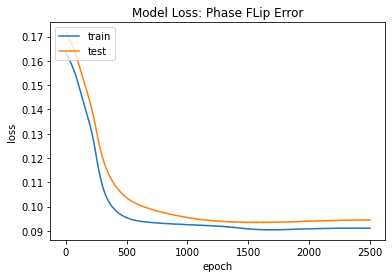

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9014199899138139-2.7306277933457756e-09j), shape=(), dtype=complex128)
